### Setup

In [1]:
%matplotlib inline
from matplotlib.colors import LogNorm

import astropy.units as u
from astropy.table import Table
from astropy.io import fits
from astropy.coordinates import SkyCoord, Angle

from gammapy.maps import MapAxis, WcsNDMap, Map
from gammapy.modeling.models import (
    TableModel, PowerLaw, SkyDiffuseMap,
    SkyModel, BackgroundModel
)
from gammapy.cube import MapDataset, PSFKernel
from gammapy.irf import load_cta_irfs
from gammapy.cube import make_map_exposure_true_energy, make_map_background_irf
from gammapy.spectrum import FluxPoints

import healpy as hp
import numpy as np

In [2]:
!/Users/jer/anaconda/envs/gammapy-0.10/bin/gammapy info


System:

	python_executable      : /Users/jer/anaconda/envs/gammapy-0.10/bin/python 
	python_version         : 3.6.7      
	machine                : x86_64     
	system                 : Darwin     


Gammapy package:

	path                   : /Users/jer/anaconda/envs/gammapy-0.10/lib/python3.6/site-packages/gammapy 
	version                : 0.10       


Other packages:

	numpy                  : 1.16.1     
	scipy                  : 1.2.0      
	matplotlib             : 2.2.3      
	cython                 : not installed 
	astropy                : 3.1.1      
	astropy_healpix        : 0.4        
	reproject              : 0.4        
	sherpa                 : 4.10.2     
	pytest                 : 4.2.0      
	sphinx                 : not installed 
	healpy                 : 1.11.0     
	regions                : 0.3        
	iminuit                : 1.3.3      
	naima                  : 0.8.3      
	uncertainties          : 3.0.3      


Gammapy environment variables:

	GAMMA_CAT  

### Load IRFs

In [3]:
filename = (
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)
irfs = load_cta_irfs(filename)

### Prepare model from an ASCII Table

In [4]:
opts = {
   'format': 'ascii',
   'names': ['e_ref', 'e2_flux'], 
}

t = Table.read('../datasets/spectra_CIRELLI11_EW_GAMMA_m2000.txt', **opts)

# Let's add some units
t['e_ref'].unit, t['e2_flux'].unit = "MeV", "cm-2 s-1 MeV"

In [5]:
t

e_ref,e2_flux
MeV,MeV / (cm2 s)
float64,float64
1000.0,3.61e-12
1089.8,3.95e-12
1187.8,4.33e-12
1294.5,4.73e-12
1410.8,5.16e-12
1537.5,5.62e-12
1675.6,6.11e-12
1826.2,6.64e-12


In [6]:
### Boost flux
t['dnde'] = t['e2_flux']/(t['e_ref']*t['e_ref'])*10e3
t['dnde'].unit = "cm-2 s-1 MeV-1"

In [7]:
t

e_ref,e2_flux,dnde
MeV,MeV / (cm2 s),1 / (cm2 MeV s)
float64,float64,float64
1000.0,3.61e-12,3.61e-14
1089.8,3.95e-12,3.325856359177129e-14
1187.8,4.33e-12,3.069030853357e-14
1294.5,4.73e-12,2.8226500058705753e-14
1410.8,5.16e-12,2.5925002063951717e-14
1537.5,5.62e-12,2.3774208473792055e-14
1675.6,6.11e-12,2.176208523032706e-14
1826.2,6.64e-12,1.9910006530602085e-14


### Define spectral model

In [8]:
offset = 0.5 * u.deg
energy = t['e_ref'].data * t['e_ref'].unit
values = t['dnde'].data * t['dnde'].unit

In [9]:
spectral_model = TableModel(
    energy=energy,
    values=values,
)

In [10]:
#spectral_model = PowerLaw(
#    index=3, amplitude="1e-11 cm-2 s-1 TeV-1", reference="1 TeV"
#)

### FITS image conversion

**We convert the Clumpy Healpix FITS spatial template for the integrated fluxes to a WCS FITS entering in the terminal the commnad line below.**

``
python makeFitsImage.py -i output/annihil_rs01_gamma052D_FOVdiameter2.0deg_nside1024.fits -e 3 -c 3
``

In [11]:
spatial_template = '../datasets/annihil_Perseus_A4262D_FOVdiameter2.0deg_nside1024-INTEGRATED_FLUXES-Flux_gamma-image.fits'
#spatial_template = '../datasets/annihil_Perseus_A4262D_FOVdiameter2.0deg_nside1024-INTEGRATED_FLUXES-Intensity_gamma-image.fits'
hdulist = fits.open(spatial_template)
hdulist.info()

Filename: ../datasets/annihil_Perseus_A4262D_FOVdiameter2.0deg_nside1024-INTEGRATED_FLUXES-Flux_gamma-image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Skymap        1 PrimaryHDU     153   (73, 73)   float32   


In [12]:
#hdu = hdulist[0]
#hdu.header

In [13]:
map_dm = Map.read(spatial_template)

keyword looks very much like CDELTia but isn't. [astropy.wcs.wcs]


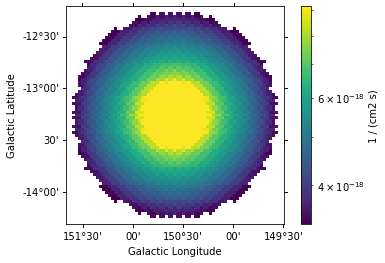

In [14]:
map_dm.plot(cmap="viridis", vmax=map_dm.data[map_dm.data>0].max()/50, norm=LogNorm(), add_cbar=True);

### Define 3D model

In [15]:
map_dm.data[map_dm.data<0] = 0

In [16]:
# Define sky model to simulate the data
spatial_model = SkyDiffuseMap(map_dm)
sky_model = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model
)

### Extend map geometry with the energy axis

In [17]:
geom3d = map_dm.geom.to_cube([energy])
geom3d.axes[0].name = 'energy'
geom3d.axes[0].unit = energy.unit

In [18]:
geom3d.axes

[MapAxis
 
 	name       : energy    
 	unit       : 'MeV'     
 	nbins      : 99        
 	node type  : edges     
 	edges min  : 1.0e+03 MeV
 	edges max  : 5.0e+06 MeV
 	interp     : lin       ]

### Simulate and display IRFs images

**We will use a single observation of 1 hour pointing to center of our Clumpy map**


In [19]:
pointing = SkyCoord(150.6, -13.3, unit="deg", frame="galactic")
livetime = 5 * u.hour
offset = Angle("0.5 deg")

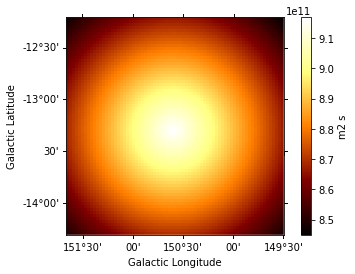

In [20]:
exposure = make_map_exposure_true_energy(
    pointing=pointing, livetime=livetime, aeff=irfs["aeff"], geom=geom3d
)
exposure.sum_over_axes().plot(add_cbar=True);

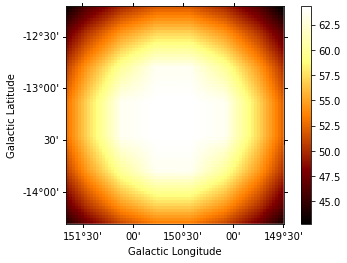

In [21]:
background = make_map_background_irf(
    pointing=pointing, ontime=livetime, bkg=irfs["bkg"], geom=geom3d
)
background.sum_over_axes().plot(add_cbar=True);

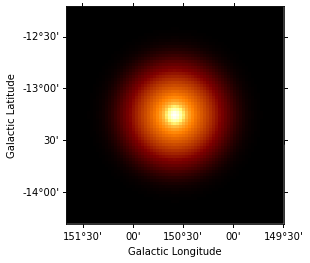

In [22]:
psf = irfs["psf"].to_energy_dependent_table_psf(theta=offset)
psf_kernel = PSFKernel.from_table_psf(psf, geom3d)
psf_kernel.psf_kernel_map.sum_over_axes().plot(stretch="log");

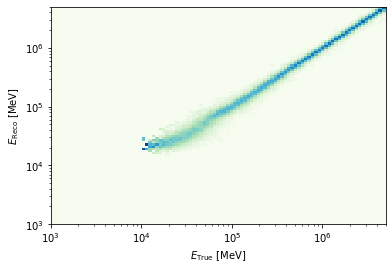

In [23]:
energy = geom3d.axes[0].edges
edisp = irfs["edisp"].to_energy_dispersion(offset=offset, e_reco=energy, e_true=energy)
edisp.plot_matrix();

### Estimate the counts from the model and IRFs

In [24]:
background_model = BackgroundModel(background)
dataset = MapDataset(
    model=sky_model,
    exposure=exposure,
    background_model=background_model,
    psf=psf_kernel,
    edisp=edisp,
)

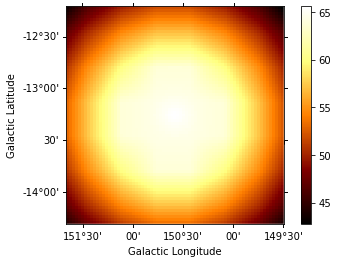

In [25]:
npred = dataset.npred()
npred.sum_over_axes().plot(add_cbar=True);

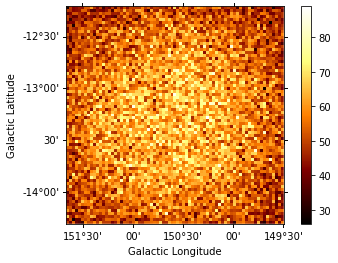

In [26]:
# This one line is the core of how to simulate data when
# using binned simulation / analysis: you Poisson fluctuate
# npred to obtain simulated observed counts.
# Compute counts as a Poisson fluctuation
rng = np.random.RandomState(seed=42)
counts = rng.poisson(npred.data)
counts_map = WcsNDMap(geom3d, counts)
counts_map.sum_over_axes().plot(add_cbar=True);

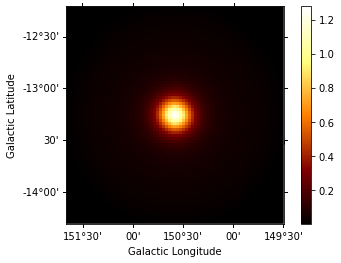

In [27]:
excess = npred.copy()
excess.data -= background.data
excess.sum_over_axes().plot(add_cbar=True);

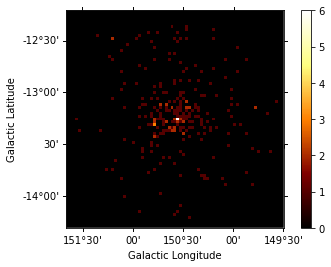

In [28]:
excess_data = excess.data
excess_data[excess.data<0]=0
excess_counts = rng.poisson(excess_data)
excess_counts_map = WcsNDMap(geom3d, excess_counts)
excess_counts_map.sum_over_axes().plot(add_cbar=True);

We can have a look at the notebook for [spectrum simulation](SimulatedSpectrumDM.ipynb) and see that the number of estimated counts for a specific energy plane may rise to > 10. Let's count then number of excess in energy plane 60.

In [29]:
excess_counts_map.slice_by_idx({'energy':50}).data.sum()

10

In this notebook we have defined the same boost for the simulated flux (10e3) and the same observation time (5h) as in the [spectrum simulation](SimulatedSpectrumDM.ipynb) notebook.

## Estimate a SED from the noisy excess counts map

Let's create a simple table with two columns: energies and fluxes to build a FluxPoint objects as it is described in the Gammapy docs. https://docs.gammapy.org/dev/api/gammapy.spectrum.FluxPoints.html

In [30]:
fluxes_table = Table()
fluxes_table.meta['SED_TYPE'] = 'dnde'
energy_axis = excess_counts_map.geom.axes[0]
energy_values = energy_axis.center
fluxes_table['e_ref'] = energy_values 

counts = []
for plane in range(len(energy_values)):
    sumcounts = excess_counts_map.slice_by_idx({'energy':plane}).data.sum()
    counts.append(sumcounts)

fluxes_table['dnde'] = counts
fluxes_table['dnde'].unit = 'cm-2 s-1 TeV-1'

In [31]:
fluxes_table

e_ref,dnde
MeV,1 / (cm2 s TeV)
float64,int64
1044.9,0
1138.8,0
1241.15,0
1352.65,0
1474.15,0
1606.55,0
1750.9,0
1908.2,0


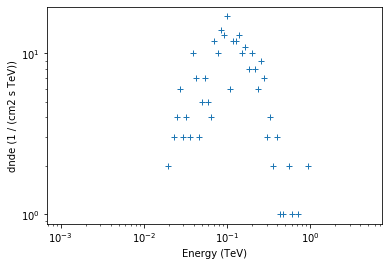

In [32]:
flux_points = FluxPoints(fluxes_table)
flux_points.plot()